# Exploratory Data Analysis

Our final dataset `nys_grad_rate22` has a nested/hierarchical structure. In this section, we'll inspect this hierarchical structure through visual representations.

In [1]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style 
import seaborn as sns 
%matplotlib inline
style.use('fivethirtyeight')

## Datasets

In [2]:
nys_gradrate_22 = pd.read_csv('data/2022_nys_gradrates_compiled.csv')
missing_df = pd.read_csv('data/missing_data.csv')

In [12]:
# reformating some column names
nys_gradrate_22 = nys_gradrate_22.rename(
    columns={'entity_cd':'beds_cd'})

In [13]:
nys_gradrate_22.head()

,beds_cd,county,district,nrc_index,school,year,subgroup,grad_rate
0,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Hispanic or Latino,73.7
1,10100010034,Albany,Albany City Sd,3,Albany High School,2022,White,86.9
2,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Multiracial,77.4
3,10100010034,Albany,Albany City Sd,3,Albany High School,2022,English Language Learner,70.4
4,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Economically Disadvantaged,75.5


In [14]:
nys_gradrate_22.shape

(4680, 8)

In [3]:
missing_df.head()

,entity_cd,entity_name,year,subgroup_name,cohort,grad_rate
0,10100010034,Albany High School,2022,American Indian or Alaska Native,Combined,s
1,10100860907,Green Tech High Charter School,2022,Hispanic or Latino,Combined,s
2,10100860907,Green Tech High Charter School,2022,White,Combined,s
3,10100860907,Green Tech High Charter School,2022,Multiracial,Combined,s
4,10100860907,Green Tech High Charter School,2022,English Language Learner,Combined,s


### Model Validation -- Interpreting Our Missing Data

In [83]:
subgroups = ["Latinx", "White", "Multiracial","ELL", "EconDis","SwD", "AAPI", "Black", "Native"]

In [80]:
nys_gradrate_22.subgroup.value_counts()

Economically Disadvantaged                         1166
White                                               782
Students with Disabilities                          748
Hispanic or Latino                                  742
Black or African American                           631
Asian or Native Hawaiian/Other Pacific Islander     272
English Language Learner                            270
Multiracial                                          54
American Indian or Alaska Native                     15
Name: subgroup, dtype: int64

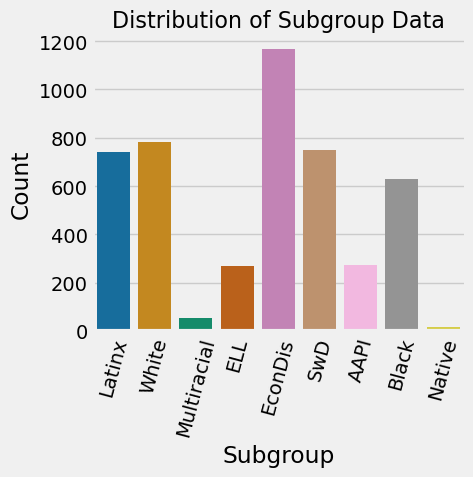

In [108]:
sns.catplot(nys_gradrate_22, x="subgroup", kind="count",palette="colorblind")
plt.xticks(ticks=list(range(0,9)),labels=subgroups,rotation=75)
plt.title("Distribution of Subgroup Data", fontsize=16)
plt.xlabel("Subgroup")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("images/subgroup_datadist.png",dpi=300)

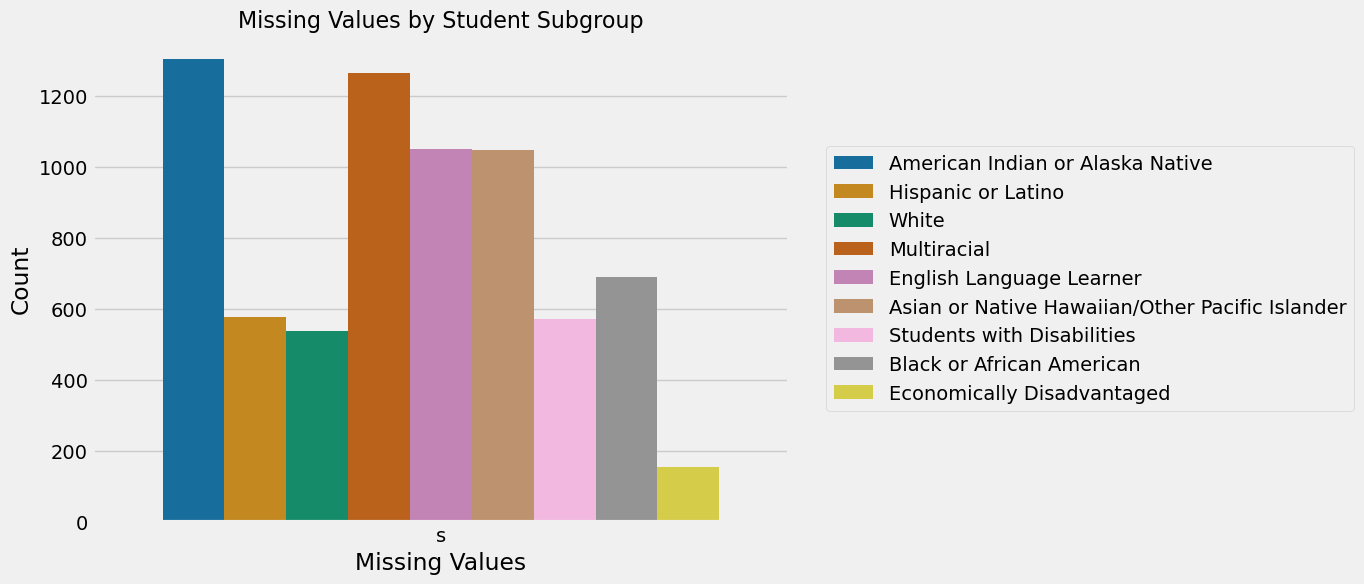

In [126]:
plt.figure(figsize=(8,6))
sns.countplot(missing_df,x="grad_rate",hue="subgroup_name",palette="colorblind")
plt.legend(loc="center left",bbox_to_anchor=(1.04,0.5))
plt.title("Missing Values by Student Subgroup", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Missing Values")
plt.savefig("images/missingvals_dist.png",dpi=300,bbox_inches="tight")

### Looking at Graduation Rate Across All Schools 

We'll start off without any assumptions about the structure of the data and visualize the graduation rates across New York State without considering `County`, `District`,`School`,`Need-to-Resource Capacity`,  or student `subgroup`. 

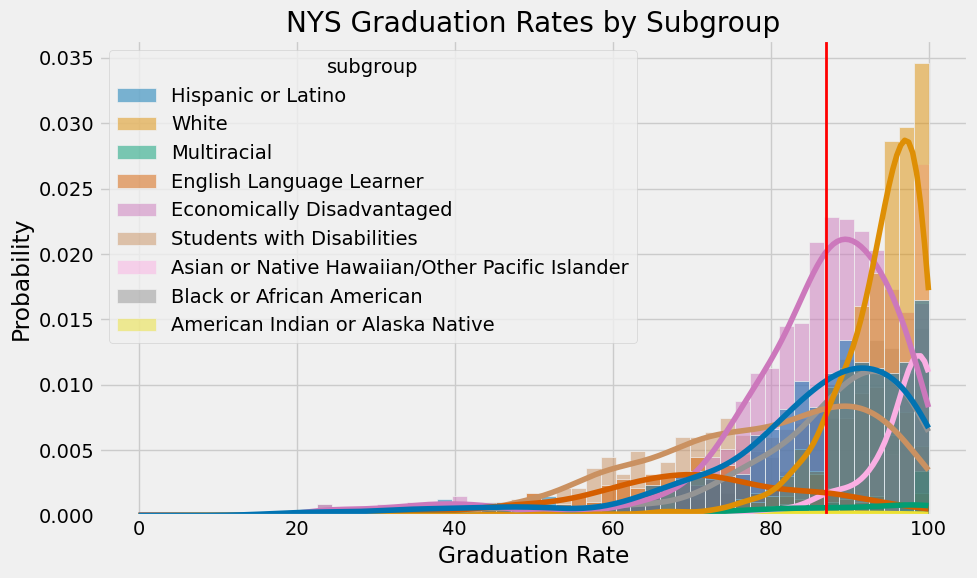

In [139]:
# creating a histogram for all 
plt.figure(figsize=(10,6))
sns.histplot(nys_gradrate_22,x="grad_rate", stat='probability', hue="subgroup",kde=True,palette="colorblind")
plt.title('NYS Graduation Rates by Subgroup')
plt.xlabel('Graduation Rate')
plt.axvline(x=87,lw=2,ls='-',c='r') 
plt.tight_layout()
#plt.savefig("images/graduationrates_subgroup.png",dpi=300)

We can see that the distribution is negatively skewed (left-tailed) with the majority of schools having higher than ~70% graduation rates. The red veritcal line at `y=87` represents the graduation rates for all students in NYS as discussed on the NYSED [site](https://data.nysed.gov/gradrate.php?year=2022&state=yes).

Looking at this graph, we have a **broad** sense of the graduation rates among schools, and can see that the majority of schools lean towards higher graduation rates above ~70%. However, looking at this chart, we fail to capture the complexity within our dataset that considers `school` and `subgroup` as important factors when looking at graduation rates. 

### Hierarchical Data Structure

Our dataset is composed with a hierarchical structure such that: 
- there are multiple **identical** records for `school` 
- each `school` record is disagregated by different student `subgroup`
- each `subgroup` **per school** has a different reported `grad_rate`

In [16]:
# looking at the nested structure through unique values 
unique_schools = len(nys_gradrate_22.school.unique())
stud_subgroups = len(nys_gradrate_22.subgroup.unique())

print(f'There are approximately {unique_schools} different schools with {stud_subgroups} different subgroups.')
print('\n')
print(f'Each school may have students grouped by the following subgroups:')
print(f'{nys_gradrate_22.subgroup.unique().tolist()}')
print('\n')
print(f'There are a possible {unique_schools * stud_subgroups} number of groups')

There are approximately 1240 different schools with 9 different subgroups.


Each school may have students grouped by the following subgroups:
['Hispanic or Latino', 'White', 'Multiracial', 'English Language Learner', 'Economically Disadvantaged', 'Students with Disabilities', 'Asian or Native Hawaiian/Other Pacific Islander', 'Black or African American', 'American Indian or Alaska Native']


There are a possible 11160 number of groups


### NYSED Redacted Information 

The `NYSED (New York State Education Department)` in compliance of `FERPA (Family Educational Rights and Privacy Act)` and other state and federal policies redacts any information for a given subgroup where the number of students in a given subgroup < a specified value. We can verify if information is redacted if a record contains a value of `'s'`

As a sanity check from our preprocessing steps, we'll verify that there are no records included in our final dataset that are redacted.

In [17]:
# sanity check after cleaning data 
's' in nys_gradrate_22.values

False

## Graduation Rate by School 

In [18]:
# we'll start of by sampling from our original dataset 

# setting a random seed for reproducibility purposes 
np.random.seed(1259)

# getting a random set of 10 schools from our original datasets and creating a list 
samp_schools = np.random.choice(nys_gradrate_22.school.unique(),size=12)

# creating a new dataframe using our sampled schools 
samp_sch_df = nys_gradrate_22[nys_gradrate_22.school.isin(samp_schools)]

# for now, we are generalizing on student subgroup and just want to know the grad_rate by school 
samp_sch_df = samp_sch_df.loc[:,['school','subgroup','grad_rate']].sort_values(by='grad_rate',ascending=False)

# grouping sampled school by school irrespective of student subgroup 
# the avg grad rate per school avg on subgroup and cohort
samp_sch_df.groupby('school').mean(numeric_only=True)

,grad_rate
school,
Batavia High School,94.350000
Bronx Leadership Acad Ii High School,77.420000
Buffalo Academy Of Science Cs,97.500000
Forest Hills High School,87.687500
Hicksville High School,90.171429
Manhattan Village Academy,98.800000
New Hartford Senior High School,98.433333
New Visions Charter Hs-Humanities Iv,91.450000
Queens Satellite Hs-Opportunity,41.333333


<Figure size 100x200 with 0 Axes>

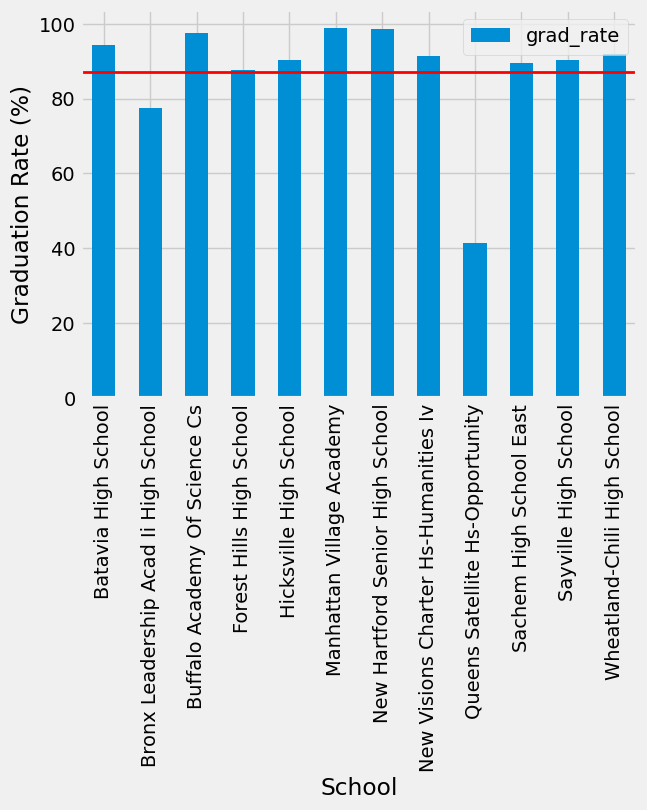

In [19]:
plt.figure(figsize=(1,2))
samp_sch_df.groupby('school').mean(numeric_only=True).plot(kind='bar')
plt.ylabel('Graduation Rate (%)')
plt.xlabel('School')
plt.axhline(y=87,lw=2,ls='-',c='r') 

Within our sample of 12 schools (~ <1% of the total number of schools), without considering the different possible subgroups of students, we have a **limited** understanding of the hierarchical nature contained within our dataset. We might assume that schools such as `Bronx Leadership`, `Forest Hills High School`, and `Queens Satellite HS` are underperforming by an arbitrary graduation rate of ~ 85% (this number is random).

However, let's closely inspect the graduation rates among the different subgroups of students within each school. This considers the hierarchical nature of the dataset and allows for a more nuanced grasp of the data. Let's do this for `Forest Hills High School`, a school we've identified as an **underperforming school** by our arbitrary measure. 

### Graduation Rates Among Our Sampled School 

### Looking at One Sampled School

In [20]:
# separating one school from the sampled list of schools 
fhs_df = samp_sch_df[samp_sch_df.school == 'Forest Hills High School'].copy()

# graduation rates by subgroup for one school in our sample 
fhs_df.groupby('subgroup').last()['grad_rate']

subgroup
Asian or Native Hawaiian/Other Pacific Islander    95.5
Black or African American                          92.7
Economically Disadvantaged                         92.3
English Language Learner                           65.2
Hispanic or Latino                                 90.3
Multiracial                                        93.9
Students with Disabilities                         79.4
White                                              92.2
Name: grad_rate, dtype: float64

In [21]:
# need to convert our subgroups into categories
fhs_df.subgroup = fhs_df.subgroup.astype('category')

# rename category names for ease of plotting
fhs_df.subgroup = fhs_df.subgroup.cat.rename_categories(
    {'Asian or Native Hawaiian/Other Pacific Islander':'AAPI_NH',
     'Black or African American':'B_AA',
     'Economically Disadvantaged':'ECDIS',
     'English Language Learner':'ELL',
     'Hispanic or Latino':'HIS_LAT',
     'Multiracial':'MuR',
     'Students with Disabilities':'SwD',
     'White':'White'})

<Figure size 400x600 with 0 Axes>

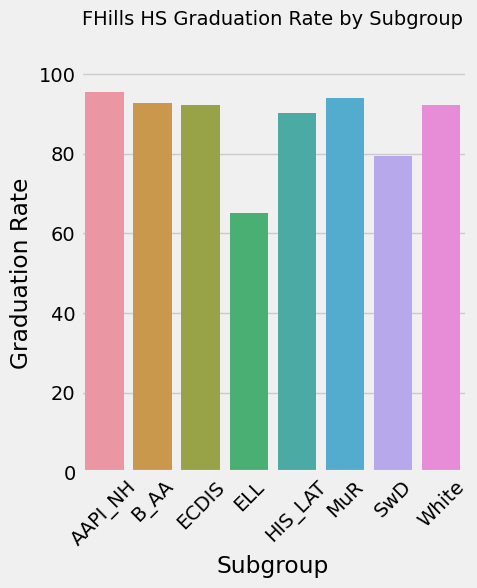

In [22]:
# visualizing the distribution graduation rates for FHills HS by subgroup
plt.figure(figsize=(4,6))
sns.catplot(fhs_df, x='subgroup', y='grad_rate', kind='bar')
plt.title('FHills HS Graduation Rate by Subgroup', fontsize=14, y=1.10)
plt.ylabel('Graduation Rate')
plt.xlabel('Subgroup')
plt.xticks(rotation=45)
plt.show()

Accounting for the variation in graduation rates provided by the effects of varying `subgroup`s of students, a much clearer picture is described. On a school-level, `Forest Hills High School` underperforms compared to others, but taking into account the different subgroups of students, we see that the `grad_rate`s for `Students with Disabilities` and `English Language Learner` is actually very important to consider.

### Looking at All Schools Within Sample 

In [23]:
# need to convert our subgroups into categories 
samp_sch_df.subgroup = samp_sch_df.subgroup.astype('category')

# rename categories for ease of plotting 
samp_sch_df.subgroup = samp_sch_df.subgroup.cat.rename_categories(
    {'Asian or Native Hawaiian/Other Pacific Islander':'AAPI_NH',
     'Black or African American':'B_AA',
     'Economically Disadvantaged':'ECDIS',
     'English Language Learner':'ELL',
     'Hispanic or Latino':'HIS_LAT',
     'Multiracial':'MuR',
     'Students with Disabilities':'SwD',
     'White':'White'})

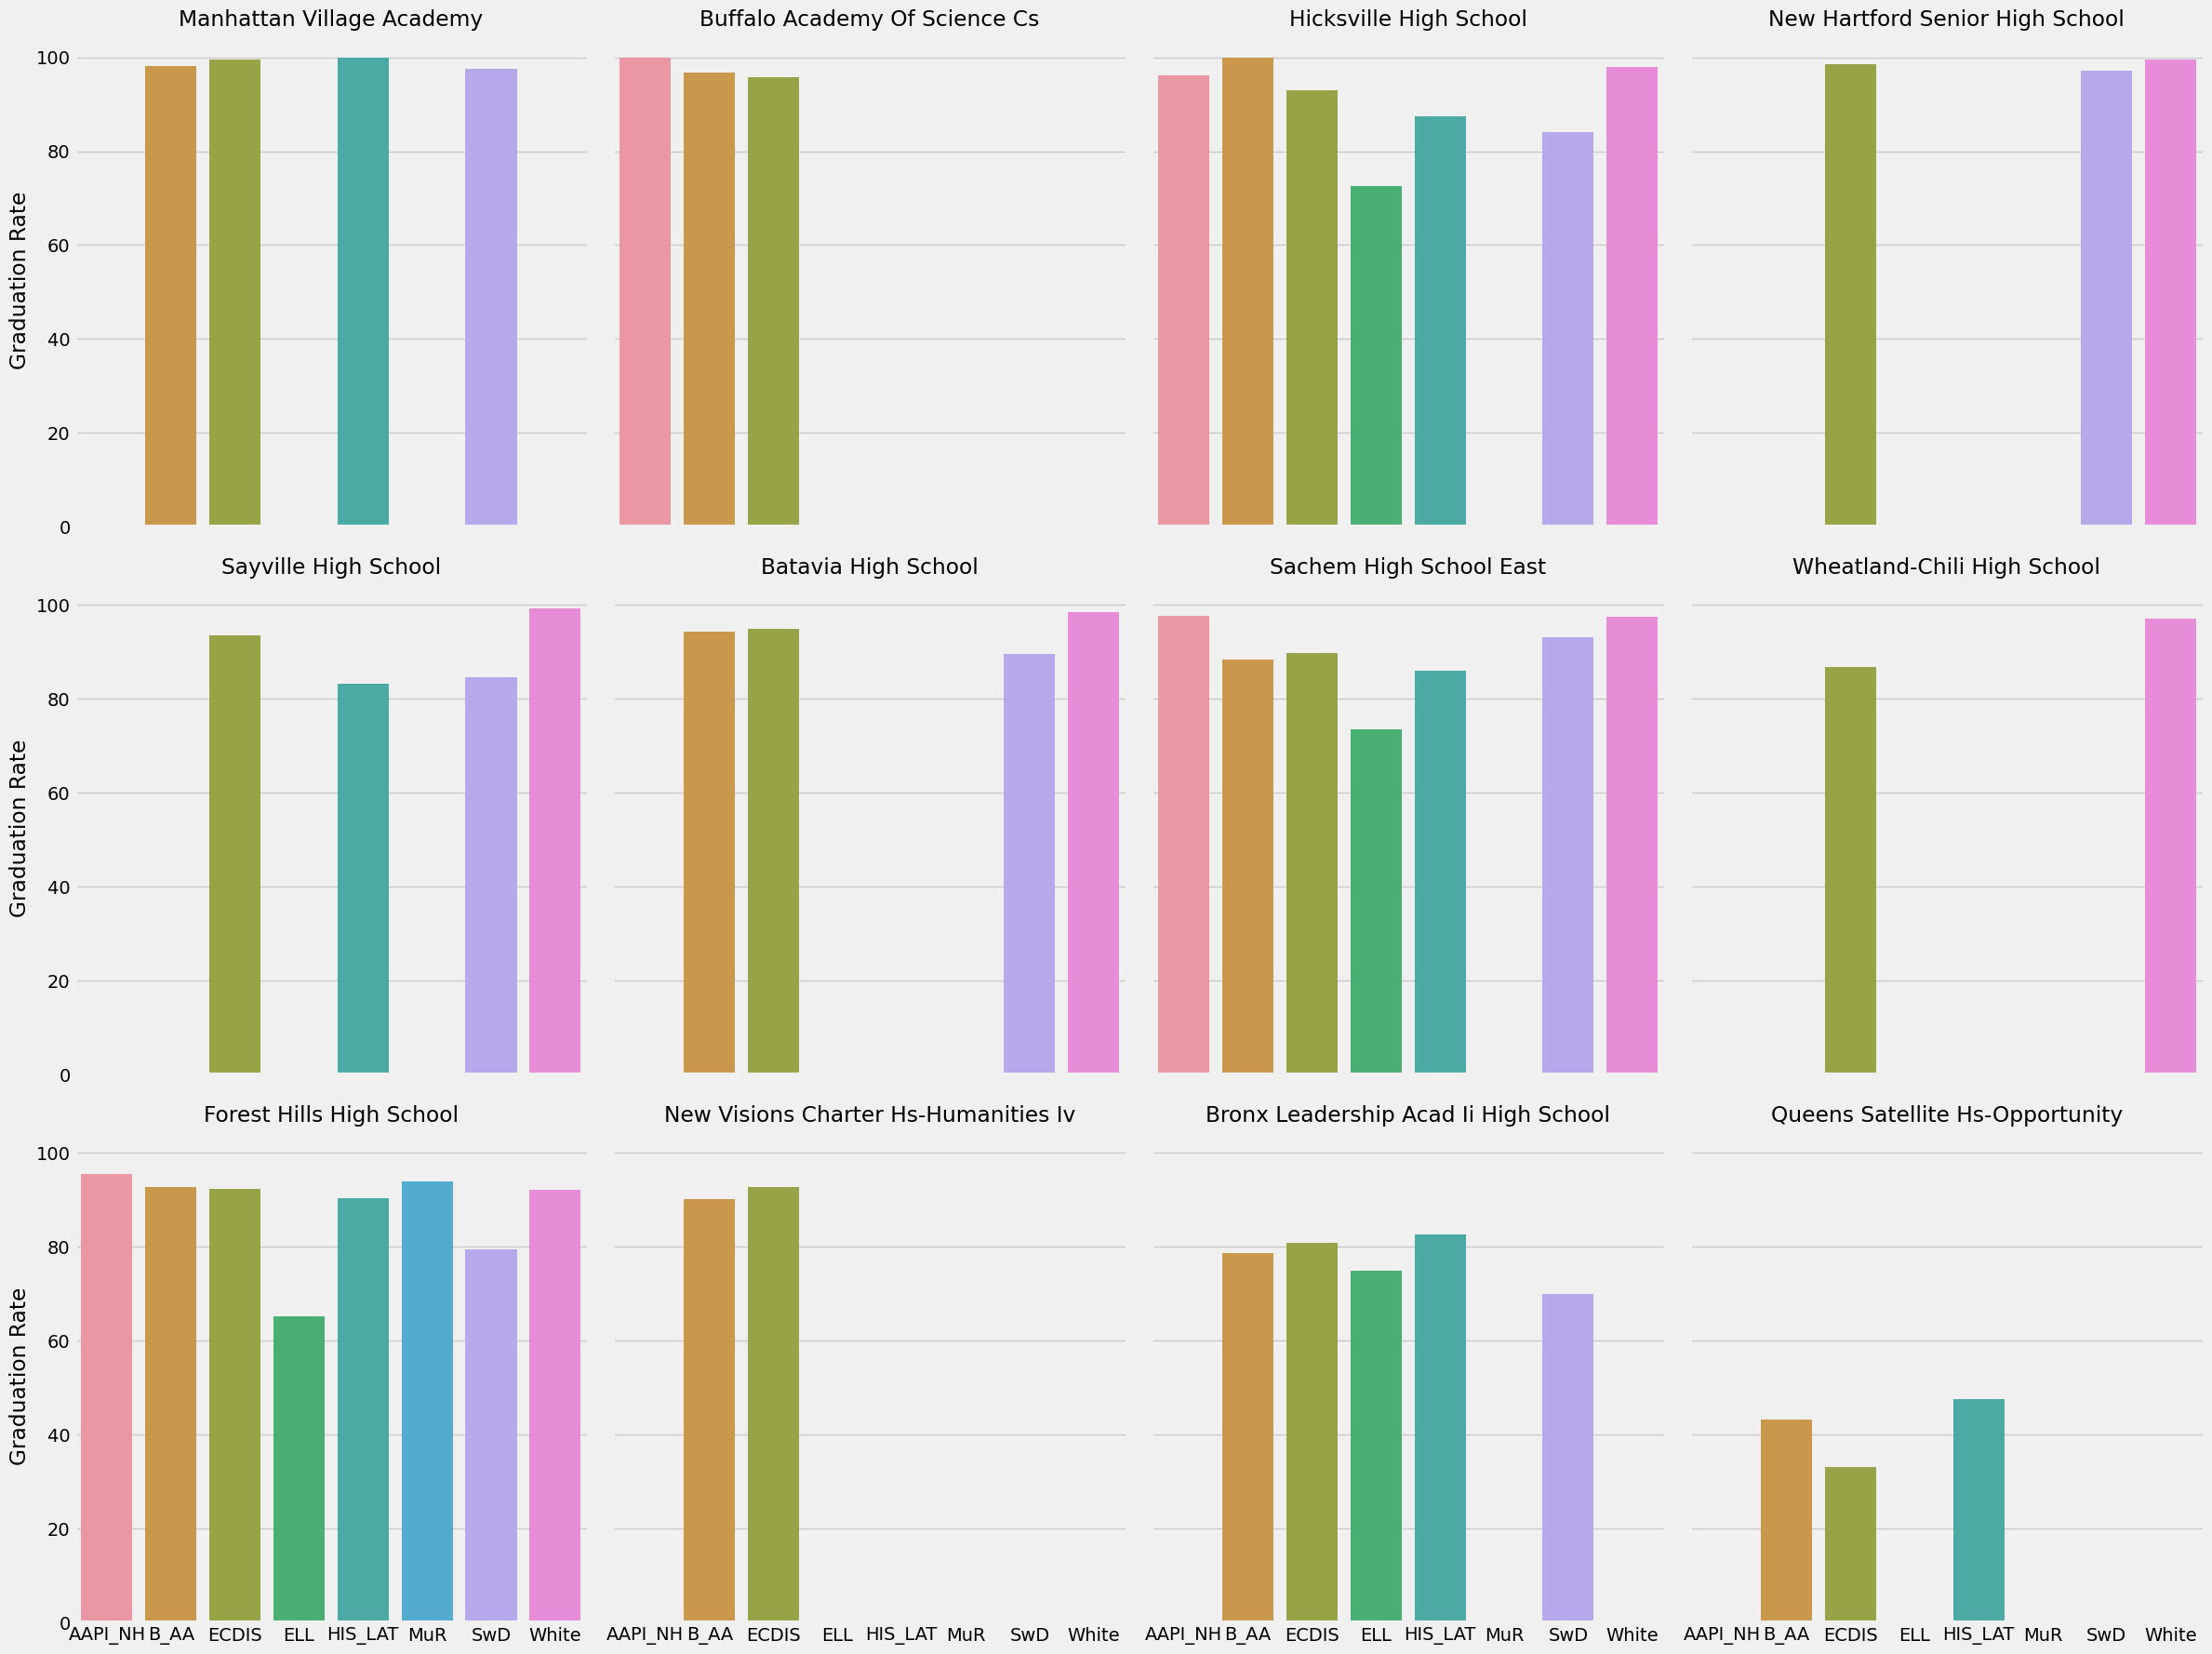

In [24]:
p = sns.catplot(samp_sch_df,x='subgroup',y='grad_rate',kind='bar',col='school',
            col_wrap=4,height=6)
p.set_titles(col_template='{col_name}')
p.set_axis_labels("","Graduation Rate")
p.tight_layout()
plt.show()

**Conclusion:**

Looking within our sample of 10 schools from the original dataset, we get a different picture of the variation within graduation rates across not just schools, but within different subgroups of students. For instance, we can see that between schools with reported `ELL` graduation rates, `Forest Hills High School` has the lowest reported rate. `White` and `AAPI_NH `students consistently have high graduation rates. `ECDIS` (Economically Disadvantaged) students have low graduation rates in schools such as `Queens Satellite HS`, an opportunity school for transfer students (see [here](https://www.qshso.org/)). `SWD` have one of the highest graduation rates in schools like `Manhatten Village Academy` and `New Hartford Senior High School`. 